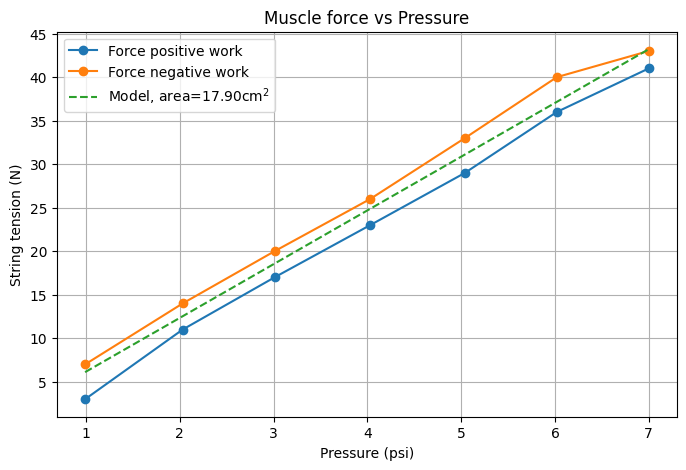

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV data
df = pd.read_csv("pressuredata.csv")

pressure = df['psi']*6894.76

# Plot force_poswork and force_negwork vs psi
plt.figure(figsize=(8,5))
plt.plot(df['psi'], df['force_poswork'], marker='o', label='Force positive work')
plt.plot(df['psi'], df['force_negwork'], marker='o', label='Force negative work')

tube_cirmcumference = 0.075*2
radius = tube_cirmcumference/(2*np.pi)
area = np.pi * radius**2

forces = 0.5*area*pressure
plt.plot(df['psi'], forces, '--', label=fr"Model, area={area*100**2:.2f}cm$^2$")


plt.xlabel('Pressure (psi)')
plt.ylabel('String tension (N)')
plt.title('Muscle force vs Pressure')
plt.legend()
plt.grid(True)
plt.show()


max_power: 7851.752688
0 78.34603638780634
1 39.17301819390317
2 19.586509096951584
3 13.057672731301057


(0.0, 1000.0)

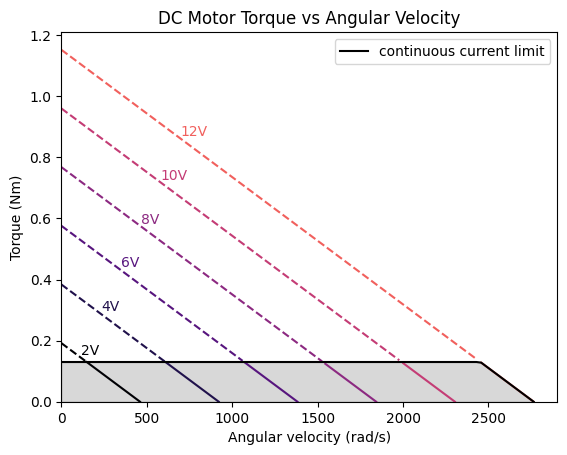

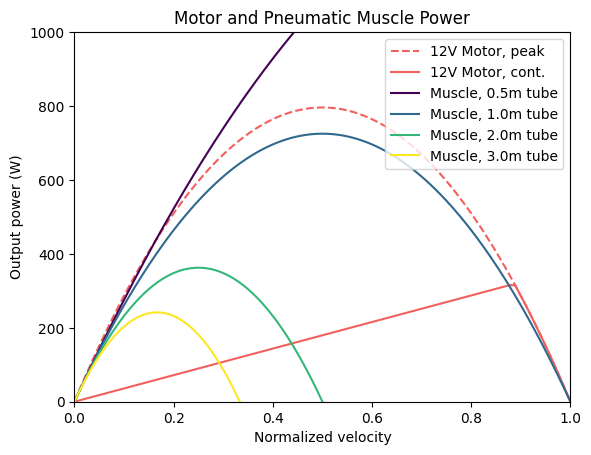

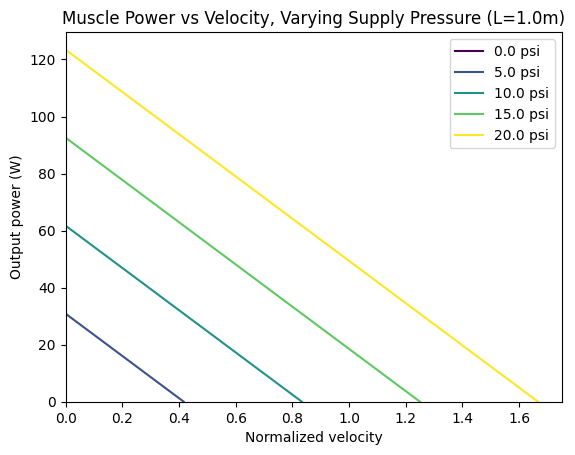

In [83]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
PI = np.pi

max_rpm_1V = 2200
max_radps_1V = max_rpm_1V * 2*PI/60
max_torque_1V = 0.096
still_air_continuous_torque = 0.130

fig, ax_force = plt.subplots()
fig, ax_power = plt.subplots()

voltages = np.linspace(2, 12, 6)
cmap = cm.magma
norm = mcolors.Normalize(vmin=voltages.min(), vmax=voltages.max()+5)

for voltage in voltages:
    omega = np.linspace(0, voltage*max_radps_1V, 100)
    torque_motor = max_torque_1V*(voltage/1 - omega/max_radps_1V)
    torque_motor_clip = np.clip(torque_motor, 0, still_air_continuous_torque)
    P_motor = torque_motor * omega
    P_motor_clip = torque_motor_clip * omega

    # Plot torque curve
    # Plot above and below the still_air_continuous_torque threshold with different styles
    mask_above = torque_motor > still_air_continuous_torque
    mask_below = ~mask_above

    # Indices where the threshold is crossed
    if np.any(mask_above):
        ax_force.plot(omega[mask_above], torque_motor[mask_above], '--', color=cmap(norm(voltage)))
    if np.any(mask_below):
        ax_force.plot(omega[mask_below], torque_motor[mask_below], '-', color=cmap(norm(voltage)))
    ax_force.text(
        omega[len(omega)//4], torque_motor[len(torque_motor)//4],
        f'{voltage:.0f}V', 
        color=cmap(norm(voltage)), 
        fontsize=10, va='bottom', ha='left'
    )

    if voltage==12:
        line_pow, = ax_power.plot(omega/(max(voltages)*max_radps_1V), P_motor, '--', color=cmap(norm(voltage)), label='12V Motor, peak')
        line_pow, = ax_power.plot(omega/(max(voltages)*max_radps_1V), P_motor_clip, '-', color=cmap(norm(voltage)), label='12V Motor, cont.')        
    
    
    if voltage == 12:
        ax_force.plot(omega, torque_motor_clip, color='black', label='continuous current limit')
        ax_force.fill_between(omega, torque_motor_clip, color='gray', alpha=0.3)  # color area under clipped curve
ax_force.set_xlabel('Angular velocity (rad/s)')
ax_force.set_ylabel('Torque (Nm)')
ax_force.set_title('DC Motor Torque vs Angular Velocity')
ax_force.legend()
ax_force.set_xlim(0, None)
ax_force.set_ylim(0, None)


psi_to_pascal = 6894.76

r_muscle = 0.02387
A_muscle = PI*r_muscle**2
r_tube = 0.0025
A_tube = PI*r_tube**2
mu = 1.81e-5

p_supply = 12 * psi_to_pascal 

max_Q = 0.0949 #flow rate in m^3/s, depends on orifice
max_power = max_Q * p_supply
print(f"max_power: {max_power}")

L_vals = [0.5, 1, 2, 3]  # Vary L from 1m to 6m in 5 steps
colors = cm.viridis(np.linspace(0, 1, len(L_vals)))

max_v_global = np.max([(1/2*p_supply*A_muscle)/(4*PI*mu*L*(A_muscle**2 / A_tube**2)) for L in L_vals])

for i, L in enumerate(L_vals):
    max_v = (1/2*p_supply*A_muscle)/(4*PI*mu*L*(A_muscle**2 / A_tube**2))
    print(i, max_v)
    v = np.linspace(0, max_v, 200)
    
    F_muscle = 1/2*p_supply*A_muscle - 4*PI*mu*L*(A_muscle**2 / A_tube**2)*v
    P_muscle = F_muscle * v


    ax_power.plot(
        v/39.17262646763849, P_muscle, 
        color=colors[i], 
        label=f'Muscle, {L:.1f}m tube'
    )

# Additional plot: Vary supply pressure psi
fig_psi, ax_psi = plt.subplots()
psi_vals = np.arange(0, 20.1, 5)  # psi values to test
psicolors = cm.viridis(np.linspace(0, 1, len(psi_vals)))
L = 1.0  # fix tube length for this plot
for j, psi in enumerate(psi_vals):
    p_supply_var = psi * psi_to_pascal
    max_v_psi = (1/2*p_supply_var*A_muscle)/(4*PI*mu*L*(A_muscle**2 / A_tube**2))
    v_psi = np.linspace(0, max_v_psi, 200)
    F_muscle_psi = 1/2*p_supply_var*A_muscle - 4*PI*mu*L*(A_muscle**2 / A_tube**2)*v_psi
    ax_psi.plot(
        v_psi/39.17262646763849, F_muscle_psi,
        color=psicolors[j],
        label=f'{psi:.1f} psi'
    )

ax_psi.set_xlabel('Normalized velocity')
ax_psi.set_ylabel('Output power (W)')
ax_psi.set_title(f'Muscle Power vs Velocity, Varying Supply Pressure (L={L:.1f}m)')
ax_psi.legend()
ax_psi.set_xlim(0, None)
ax_psi.set_ylim(0, None)

    

ax_power.set_xlabel('Normalized velocity')
ax_power.set_ylabel('Output power (W)')
ax_power.set_title('Motor and Pneumatic Muscle Power')
# ax_power.grid()
ax_power.legend()
ax_power.set_xlim(0, 1)
ax_power.set_ylim(0, 1000)

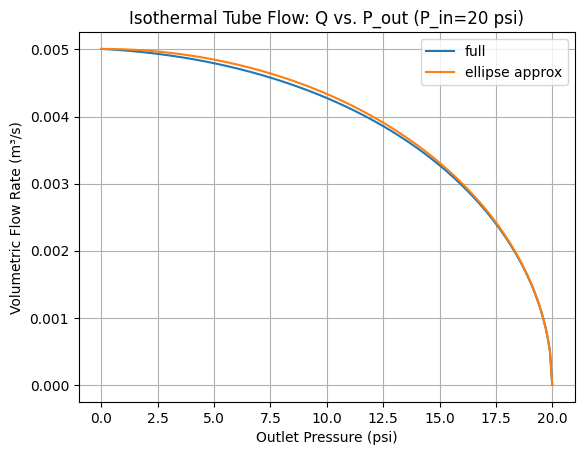

In [115]:
R = 287.05           # Gas constant for air (J/kg·K)
MU = 1.81e-5         # Dynamic viscosity of air (Pa·s)
RHO_STD = 1.204      # Standard air density (kg/m³)
P_ATM = 101325.0     # Atmospheric pressure (Pa)

import matplotlib.pyplot as plt
import numpy as np

f = 0.021
T0 = 293.15
D = 0.005
A = np.pi * (D / 2)**2    # m²
length = 1.0  # or use whatever value appropriate / variable in your analysis
P_in_psi = 20  # Fix inlet pressure in psi for this analysis
P_in = P_in_psi * 6894.76 + P_ATM  # absolute Pa

plt.figure()

P_out_psi_vals = np.linspace(0, P_in_psi, 200)
P_out_vals = P_out_psi_vals * 6894.76 + P_ATM  # convert psi to Pa (absolute)

m_dot = A * np.sqrt((P_in**2 - P_out_vals**2) / (R * T0 * (f * length / D + 2 * np.log(P_in / P_out_vals))))
q_isothermal = m_dot / RHO_STD
plt.plot(P_out_psi_vals, q_isothermal, label='full')

# Approximate Q vs P_out as an ellipse between (P_in, Q=0) and (P_out=0, Q_max)
p_out_approx = A / RHO_STD * np.sqrt((P_in**2 - P_ATM**2) / (R * T0 * (f * length / D + 2 * np.log(P_in / P_ATM)))) * np.sqrt(1 - (P_out_psi_vals / P_in_psi)**2)
plt.plot(P_out_psi_vals, p_out_approx, label='ellipse approx')

# m_dot = A * np.sqrt((P_in**2 - P_out_vals**2) / (R * T0 * (f * length / D )))
# q_isothermal = m_dot / RHO_STD
# plt.plot(P_out_psi_vals, q_isothermal, label='approx')


plt.xlabel('Outlet Pressure (psi)')
plt.ylabel('Volumetric Flow Rate (m³/s)')
plt.title(f'Isothermal Tube Flow: Q vs. P_out (P_in={P_in_psi} psi)')
plt.grid(True)
plt.legend()

39.99999537800488


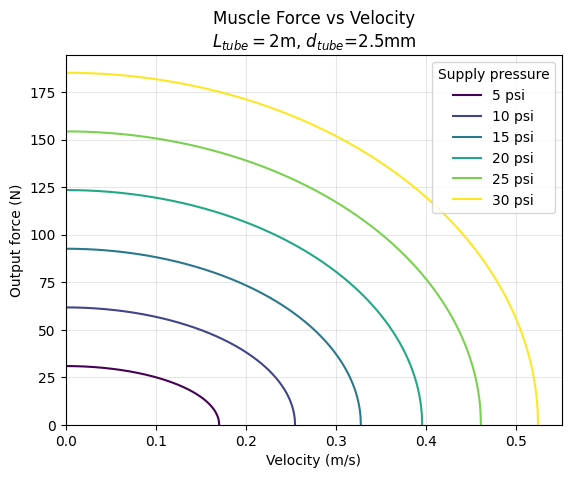

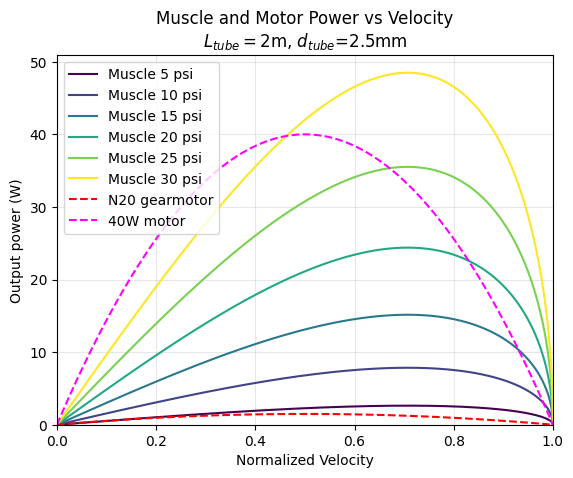

In [243]:
fig_force, ax_force = plt.subplots()
fig_power, ax_power = plt.subplots()

rho = 1.204 #air density, 20C
p_atm = 101325 #Pa at sea level
psi_to_pascal = 6894.76
f_darcy = 0.021 #guess for darcy friction factor for smooth tubing

L_tube = 2.0 #tube length (m)
d_tube = 0.0025 #tube diameter (m)
A_tube = PI*(d_tube/2)**2
r_muscle = 0.02387
A_muscle = PI*r_muscle**2

psi_vals = np.arange(5, 30.1, 5)  # psi values to test
psicolors = cm.viridis(np.linspace(0, 1, len(psi_vals)))



p_supply_max = max(psi_vals) * psi_to_pascal
K_max = (rho*A_muscle/A_tube)**2 * (R*T0*(f_darcy*L_tube/d_tube + 2*np.log((p_supply_max+p_atm)/p_atm))) / ((p_supply_max+p_atm)**2 - p_atm**2)
v_max_all = 1 / np.sqrt(K_max)


for i, psi in enumerate(psi_vals):
    p_supply = psi * psi_to_pascal

    K = (rho*A_muscle/A_tube)**2 * (R*T0*(f_darcy*L_tube/d_tube + 2*np.log((p_supply+p_atm)/p_atm))) / ((p_supply+p_atm)**2 - p_atm**2)
    v_max = 1 / np.sqrt(K)

    v = np.linspace(0, v_max, 1000)

    p_muscle = p_supply * np.sqrt(np.maximum(0, 1 - K * v**2))
    F_muscle = 1/2*A_muscle*p_muscle
    ax_force.plot(
        v, F_muscle,
        color=psicolors[i],
        label=f'{psi:.0f} psi'
    )

    P_muscle = F_muscle * v
    ax_power.plot(
        v/max(v), P_muscle,
        color=psicolors[i],
        label=f'Muscle {psi:.0f} psi'
    )


#Polulu 10:1 Micro Metal Gearmotor HPCB 12V
voltage = 12
max_rpm_12V = 3400
max_radps_12V = max_rpm_12V * 2*PI/60
max_torque_12V = 1.7*9.81/1000 #Nm
continuous_torque = 1.0*9.81/1000
omega = np.linspace(0, voltage*max_radps_12V/12, 100)
torque_motor = max_torque_12V*(voltage/12 - omega/max_radps_12V)
torque_motor_clip = np.clip(torque_motor, 0, continuous_torque)
P_motor = torque_motor * omega
P_motor_clip = torque_motor_clip * omega
ax_power.plot(omega/max(omega), P_motor, '--', label='N20 gearmotor', color='red')
# plt.figure()
# plt.plot(omega, torque_motor)

#Vertiq
voltage = 12
max_rpm_1V = 4300
max_radps_1V = max_rpm_1V * 2*PI/60
max_torque_1V = 0.00246777 #Nm
omega = np.linspace(0, voltage*max_radps_1V, 100)
torque_motor = max_torque_1V*(voltage/1 - omega/max_radps_1V)
P_motor = torque_motor * omega
print(max(P_motor))
ax_power.plot(omega/max(omega), P_motor, '--', label="40W motor", color='magenta')
# plt.figure()
# plt.plot(omega, torque_motor)

ax_force.set_xlabel('Velocity (m/s)')
ax_force.set_ylabel('Output force (N)')
ax_force.set_title(f'Muscle Force vs Velocity\n$L_{{tube}}={L_tube:.0f}$m, $d_{{tube}}$={d_tube*1000}mm')
ax_force.legend(title="Supply pressure")
ax_force.set_xlim(0, None)
ax_force.set_ylim(0, None)
ax_force.grid(True, alpha=0.3)

ax_power.set_xlabel('Normalized Velocity')
ax_power.set_ylabel('Output power (W)')
ax_power.set_title(f'Muscle and Motor Power vs Velocity\n$L_{{tube}}={L_tube:.0f}$m, $d_{{tube}}$={d_tube*1000}mm')
ax_power.legend()
ax_power.set_xlim(0, 1)
ax_power.set_ylim(0, None)
ax_power.grid(True, alpha=0.3)

(0.0, 50.91836379354919)

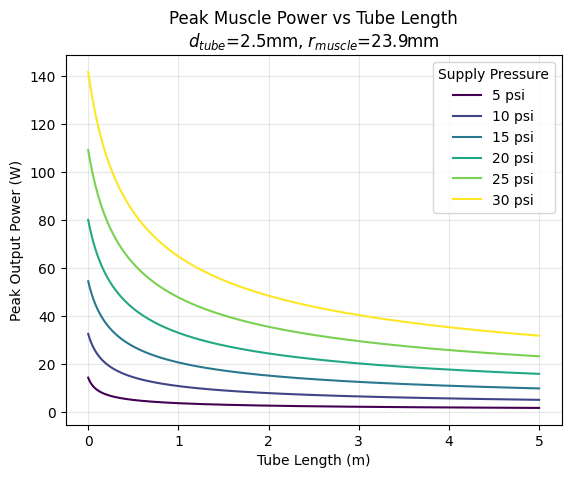

In [238]:
d_tube = 0.0025 # tube diameter (m)
A_tube = PI * (d_tube / 2) ** 2
r_muscle = 0.02387
A_muscle = PI * r_muscle ** 2

L_tube_values = np.linspace(0., 5.0, 1000)
psi_values = np.arange(5, 30.1, 5)
cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, len(psi_values)))

plt.figure()
for i, p_psi in enumerate(psi_values):
    p_supply = p_psi * psi_to_pascal
    peak_powers = []
    for L_tube in L_tube_values:
        K = (rho * A_muscle / A_tube) ** 2 * (R * T0 * (f_darcy * L_tube / d_tube + 2 * np.log((p_supply + p_atm) / p_atm))) / ((p_supply + p_atm) ** 2 - p_atm ** 2)
        v_max = 1 / np.sqrt(K)
        v = np.linspace(0, v_max, 100)
        p_muscle = p_supply * np.sqrt(np.maximum(0, 1 - K * v ** 2))
        F_muscle = 0.5 * A_muscle * p_muscle
        P_muscle = F_muscle * v
        peak_powers.append(np.nanmax(P_muscle))
    plt.plot(L_tube_values, peak_powers, label=f"{p_psi:.0f} psi", color=colors[i])

plt.xlabel("Tube Length (m)")
plt.ylabel("Peak Output Power (W)")
plt.title(f"Peak Muscle Power vs Tube Length\n$d_{{tube}}$={d_tube*1000:.1f}mm, $r_{{muscle}}$={r_muscle*1000:.1f}mm")
plt.legend(title="Supply Pressure")
plt.grid(True, alpha=0.3)
ax_power.set_xlim(0, None)
ax_power.set_ylim(0, None)

(0.0, 50.91836379354919)

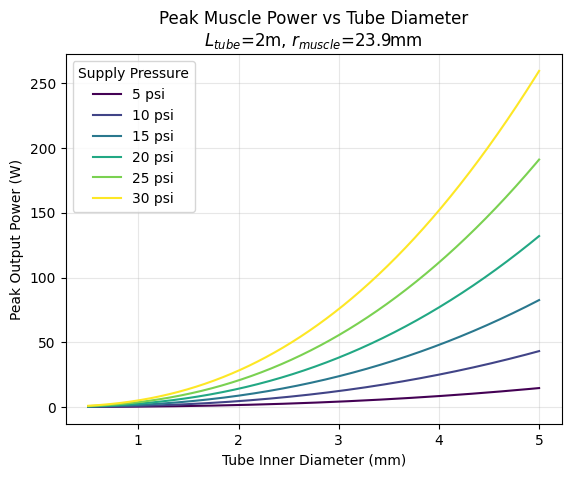

In [239]:
L_tube = 2.0  # Fix tube length (m)
r_muscle = 0.02387
A_muscle = PI * r_muscle ** 2

d_tube_values = np.linspace(0.5e-3, 5.0e-3, 1000)  # Vary d_tube from 0.5 mm to 7 mm
psi_values = np.arange(5, 30.1, 5)
cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, len(psi_values)))

plt.figure()
for i, p_psi in enumerate(psi_values):
    p_supply = p_psi * psi_to_pascal
    peak_powers = []
    for d_tube in d_tube_values:
        A_tube = PI * (d_tube / 2) ** 2
        # Compute K for current d_tube
        K = (rho * A_muscle / A_tube) ** 2 * (R * T0 * (f_darcy * L_tube / d_tube + 2 * np.log((p_supply + p_atm) / p_atm))) / ((p_supply + p_atm) ** 2 - p_atm ** 2)
        v_max = 1 / np.sqrt(K)
        v = np.linspace(0, v_max, 100)
        p_muscle = p_supply * np.sqrt(np.maximum(0, 1 - K * v ** 2))
        F_muscle = 0.5 * A_muscle * p_muscle
        P_muscle = F_muscle * v
        peak_powers.append(np.nanmax(P_muscle))
    plt.plot(d_tube_values * 1000, peak_powers, label=f"{p_psi:.0f} psi", color=colors[i]) # plot d_tube in mm

plt.xlabel("Tube Inner Diameter (mm)")
plt.ylabel("Peak Output Power (W)")
plt.title(f"Peak Muscle Power vs Tube Diameter\n$L_{{tube}}$={L_tube:.0f}m, $r_{{muscle}}$={r_muscle*1000:.1f}mm")
plt.legend(title="Supply Pressure")
plt.grid(True, alpha=0.3)
ax_power.set_xlim(0, None)
ax_power.set_ylim(0, None)